In [1]:
## IMPORTS
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric

!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt

Found existing installation: torch-scatter 2.1.2+pt21cu118
Uninstalling torch-scatter-2.1.2+pt21cu118:
  Successfully uninstalled torch-scatter-2.1.2+pt21cu118
Found existing installation: torch-sparse 0.6.18+pt21cu118
Uninstalling torch-sparse-0.6.18+pt21cu118:
  Successfully uninstalled torch-sparse-0.6.18+pt21cu118
Found existing installation: torch_geometric 2.4.0
Uninstalling torch_geometric-2.4.0:
  Successfully uninstalled torch_geometric-2.4.0
Found existing installation: torch-cluster 1.6.3+pt21cu118
Uninstalling torch-cluster-1.6.3+pt21cu118:
  Successfully uninstalled torch-cluster-1.6.3+pt21cu118
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
  Using cached https://data.pyg.org/whl/torch-2.1.0%2Bcu118/torch_scatter-2.1.2%2Bpt21cu118-cp310-cp310-linux_x86_64.whl (10.2 MB)
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
  Using cached https://data.pyg.org/whl/torch-2.1.0%2Bcu118/torch_sparse-0.6.18%2Bpt21cu118-cp310-cp310-linux_x86_64.whl 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

dataset = Planetoid(root='./data', name='Cora')  # Itt 'Cora' helyett használhatsz másik Planetoid adathalmazt is.
data = dataset[0]

In [3]:
## PARAMETERS
embedding_dim = 128
walk_length=80
context_size=10
walks_per_node=10
num_negative_samples=1
p=0.5
q=0.5

lr=0.05
epochs=50
batch_size=64

In [4]:
!pip install wandb
import wandb
wandb.login()

wandb: Currently logged in as: balintgerinm. Use `wandb login --relogin` to force relogin


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the Node2Vec model
model = Node2Vec(data.edge_index, embedding_dim, walk_length=walk_length, context_size=context_size,
                 walks_per_node=walks_per_node, num_negative_samples=num_negative_samples, p=p, q=q, sparse=True).to(device)

# Initialize the SGD optimizer with momentum
loader = model.loader(batch_size=batch_size, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=lr)

print(model)

Node2Vec(2708, 128)


In [6]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask], z[data.test_mask], data.y[data.test_mask], max_iter=150)
    return acc

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.title(f'embs_p {p}_q {q}_size {embedding_dim}')
    plt.savefig(f'embs_p {p}_q {q}_size {embedding_dim}.jpg')
    plt.show()

In [7]:
wandb.init(project="project_lab2_node2vec")
for epoch in tqdm(range(epochs)):
    loss = train()
    acc = test()
    wandb.log({"Loss": loss, "Acc": acc, "Epoch": epoch + 1})
wandb.finish()

100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


Acc,▁▅▇▆▆▇▇▇▇▆▇▇▇▇▇▇█▆▆▇▆▇▇▆▇▇▆▇▇▇▇▇▇▇▆█▇▇▆█
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.725
Epoch,50
Loss,0.8345


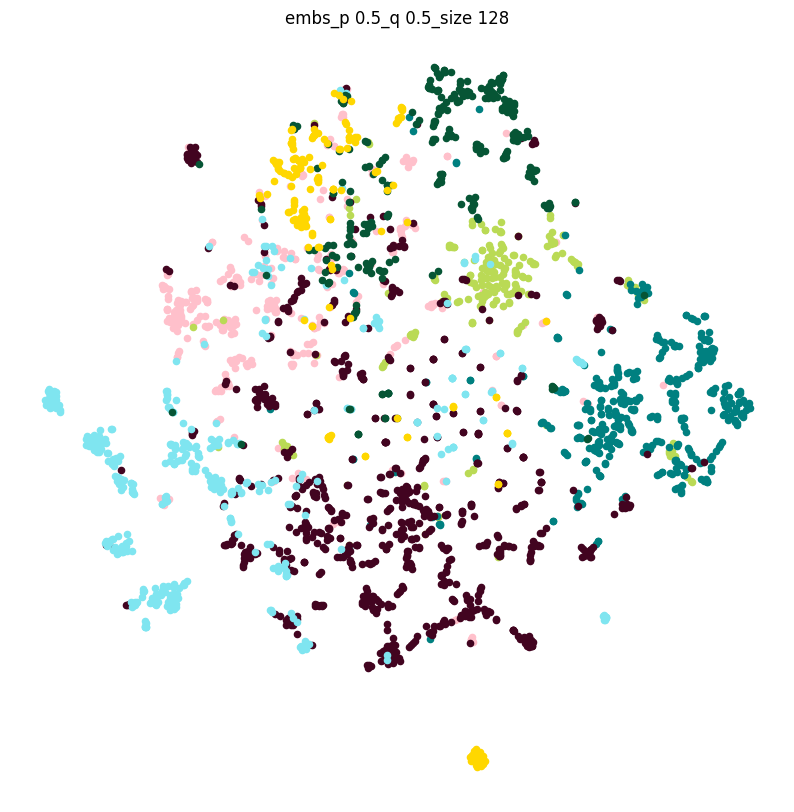

In [8]:
colors = [ '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700' ]
plot_points(colors)

In [9]:
import numpy as np
import torch
from torch_geometric.datasets import Planetoid
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Planetoid adathalmaz betöltése
dataset = Planetoid(root='./data', name='Cora')  # Használja a megfelelő adathalmaz nevet
data = dataset[0]

# Node2Vec modell beágyazások betöltése
embeddings = model()
embeddings = embeddings.cpu().detach().numpy()
# Az éleket tartalmazó gráf előkészítése
edge_index = data.edge_index

# Gráf mérete
num_nodes = data.num_nodes

# Beágyazások közötti hasonlóság kiszámítása (példában koszinusz hasonlóság)
similarity_matrix = np.dot(embeddings, embeddings.T)

matrix_size = num_nodes
matrix = np.zeros((matrix_size, matrix_size))
for i,j in edge_index.T:
  matrix[i,j] = 1

predictions = similarity_matrix.flatten()
#predictions = (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))
originals  = matrix.flatten()


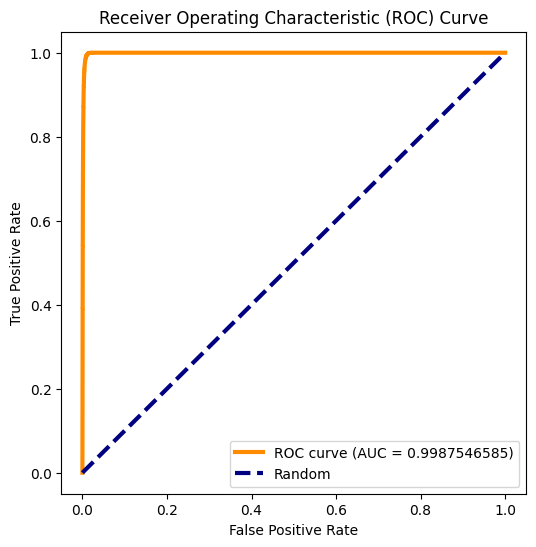

In [10]:
# ROC görbe számítása
fpr, tpr, treshold = roc_curve(originals, predictions, pos_label=1)
roc_auc = auc(fpr, tpr)

# ROC görbe ábrázolása
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.10f})')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('ROC_curve.png')
plt.show()

In [11]:
## Classifier using Linear Regression on Planetoid dataset

In [12]:
# DATAFRAME
X = embeddings
y = dataset.y
columns_X = [f'feature_{i}' for i in range(X.shape[1])]
df_X = pd.DataFrame(X, columns=columns_X)

# Add the 'y' column to the DataFrame
df_X['class'] = y

# Display the DataFrame
df_X.head(5)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,class
0,0.213624,0.000780,0.014285,0.063183,0.190012,0.400352,0.128818,-0.105393,-0.025099,0.134027,...,-0.006960,0.088324,0.040890,0.060941,-0.053067,0.024269,0.398327,0.215717,0.055752,3
1,0.076029,0.167611,0.131007,-0.310419,-0.447777,0.030344,0.089000,0.224860,0.233574,0.034207,...,-0.405406,-0.524218,-0.115470,0.095629,-0.212316,-0.133905,0.175678,-0.108445,-0.235131,4
2,0.465713,0.025725,-0.089461,-0.063961,-0.288958,-0.052631,0.099634,0.037679,-0.082564,-0.005136,...,-0.537229,-0.280967,-0.151234,0.064363,-0.088893,0.071084,0.157298,-0.202626,-0.227701,4
3,-0.081816,-0.098170,-0.028336,0.163611,0.123508,-0.129555,0.215510,0.159438,-1.137844,0.064050,...,0.226703,0.175413,0.057381,0.247747,-0.007106,-0.021684,-0.044284,-0.040645,-0.009900,0
4,-0.588159,-0.010994,0.238098,0.434553,-0.153618,0.197179,-0.314705,0.025826,0.126604,-0.194734,...,-0.065900,-0.489054,0.059441,-0.077273,0.227090,-0.175016,0.031761,0.118482,-0.031260,3


In [13]:
df_X['class'].value_counts()

3    818
4    426
2    418
0    351
5    298
1    217
6    180
Name: class, dtype: int64

In [14]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

X = df_X.drop('class', axis=1)
y = df_X['class']

df_columns = X.columns
scaler = StandardScaler()
df = scaler.fit_transform(X)
X = pd.DataFrame(df)
X.columns = df_columns

# Create a linear regression model
model = LinearRegression()

# Specify the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')  # You can use other scoring metrics

# Display the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Mean R^2:", np.mean(cross_val_scores))

Cross-Validation Scores: [0.45860282 0.49947004 0.48288435 0.43005325 0.48576151]
Mean R^2: 0.47135439571970766


In [15]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute F1 score (micro and macro)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Display the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nF1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)
print("Accuracy:", accuracy)


Confusion Matrix:
[[ 53   1   0   8   4   3   6]
 [  3  31   5   2   2   3   0]
 [  0   1  71   4   0   2   2]
 [  9  10   5 148  11   5   3]
 [  4   1   1  11  56   2   1]
 [  5   0   0   4   3  29   3]
 [  2   1   1   2   1   2  21]]

F1 Score (Micro): 0.7546125461254612
F1 Score (Macro): 0.7239007578651826
Accuracy: 0.7546125461254612


In [16]:
with open("results.txt", "w") as file:
  file.write("Parameters:\n")

  file.write(f"P= {p}\n")
  file.write(f"Q= {q}\n")
  file.write(f"Embedding Dimension= {embedding_dim}\n")
  file.write(f"Walk Length= {walk_length}\n")
  file.write(f"Context Size= {context_size}\n")
  file.write(f"Walks Per Node= {walks_per_node}\n")
  file.write(f"Learning Rate= {lr}\n")
  file.write(f"Batch Size= {batch_size}\n")
  file.write("\n")
  file.write("Results:\n")
  file.write("\n")
  file.write("Link Prediction:\n")
  file.write(f"ROC-AUC score= {roc_auc}\n")
  file.write("\n")
  file.write("Node Classification with Logistic Regression:\n")
  file.write(f"F1 Score (Micro)= {f1_micro}\n")
  file.write(f"F1 Score (Macro)= {f1_macro}\n")
  file.write(f"Accuracy= {accuracy}\n")

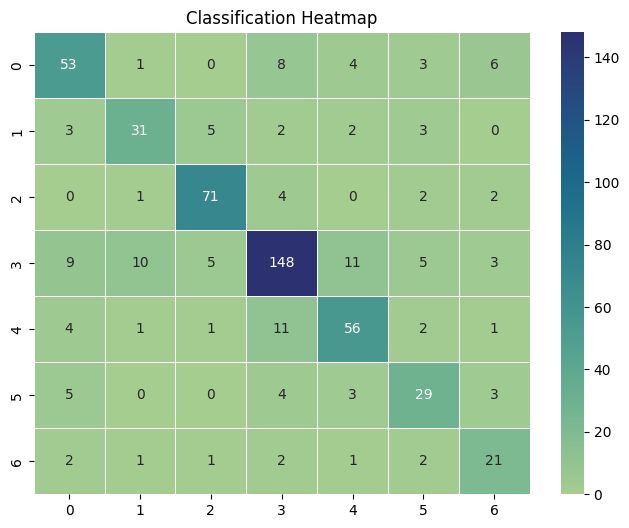

In [17]:
import seaborn as sn
df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(len(conf_matrix[0]))],
                  columns = [i for i in range(len(conf_matrix[0]))])

plt.figure(figsize = (8,6))
plt.title("Classification Heatmap")
sn.heatmap(df_cm, annot=True,fmt=".0f",linewidth=.5, cmap="crest")
plt.savefig("heatmap.png")
plt.show()